<h1 align="center"> EDA and Sentiment Analysis of Tweets Using CNN-BiLSTM and BiLSTM models </h1>

---

<h2 align="center"> Objective </h2>

<p align="justify"> The objective of this project is to create neural network models for tweet setiment analysis. A lot of research has been conducted on feature engineering methods to get better accuracy in predictions; but not much emphasis has been given to Neural Network modeling when it comes to sentiment analysis. This project will focus on nerual network modeling rather feature engineering. The models which will be used in this project are <b>"Convolutional Bidirectional Long Short Term Memory"</b> also know as CNN-BiLSTM and <b>"Bidirectional Long Short Term Memory"</b> model commonly referred to as BiLSTM model. 


---
<h2 align="center"> Contents </h2>

<ol type="I">
<h3><li> Exploratory Data Analysis </h3>
<ol type="a">
<li> Barplot
<li> Pieplot
<li> Histplot
</ol>

<h3><li> Data Preprocessing </h3>
<ol type="a">
<li> Text Cleaning
<li> Lemmatization
<li> Tokenization and padding
<li> Test Train data splitting
</ol>

<h3><li> Neural Network Modeling </h3>
<ol type="a">
<li> BiLSTM
<li> CNN-BiLSTM
</ol>

<h3><li> Result </h3>
</ol>

---




In [ ]:
# Importing Libraries

# Basic Libraries
import numpy as np
import pandas as pd 
import os
import tweepy as tw #for accessing Twitter API
import warnings

#For Preprocessing
import re  
import nltk 
nltk.download("stopwords", quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import string

# For building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

# Others

# For model creation
from keras.callbacks import LearningRateScheduler
import math
import tensorflow.keras
from tensorflow.python.eager.context import internal_operation_seed
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from tensorflow.keras import regularizers 
from keras import losses

# Intalling Orca
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Mounting google drive to import data
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


<h2 align="center"> Exploratory Data Analysis </h2>

In [3]:
# Importing first dataset
df1 = pd.read_csv("/content/drive/MyDrive/Major Project/finalSentimentdata2.csv")

df1.rename(columns={'text': 'clean_text', 
                    'sentiment':'category'},
           inplace=True)
df1['category'] = df1['category'].map({'sad': -1.0, 
                                       'anger': -1.0, 
                                       'fear': -1.0, 
                                       'joy':1.0})
df1.drop(['Unnamed: 0'],
         inplace=True,
         axis=1)
df1.head()

,category,clean_text
0,-1.0,agree the poor in india are treated badly thei...
1,1.0,if only i could have spent the with this cutie...
2,1.0,will nature conservation remain a priority in ...
3,-1.0,coronavirus disappearing in italy show this to...
4,-1.0,uk records lowest daily virus death toll since...


In [4]:
# Importing the second dataset
df2 = pd.read_csv("/content/drive/MyDrive/Major Project/covid-19_vaccine_tweets_with_sentiment.csv", 
                  encoding= 'unicode_escape')
df2.drop(['tweet_id'], 
         inplace=True,
         axis=1)
df2.rename(columns={'tweet_text': 'clean_text', 
                    'label':'category'},
           inplace=True)
df2['category'] = df2['category'].map({1: -1.0, 
                                       2: 0.0, 
                                       3: 1.0})
df2.head()

,category,clean_text
0,-1.0,"4,000 a day dying from the so called Covid-19 ..."
1,0.0,Pranam message for today manifested in Dhyan b...
2,0.0,Hyderabad-based ?@BharatBiotech? has sought fu...
3,-1.0,"Confirmation that Chinese #vaccines ""dont hav..."
4,1.0,"Lab studies suggest #Pfizer, #Moderna vaccines..."


In [5]:
# Importing third dataset
headers=['Tweet_ID','Entity','category','clean_text']
df3 = pd.read_csv("/content/drive/MyDrive/Major Project/twitter_training.csv",
                  sep=',', 
                  names=headers)
df3.drop(['Tweet_ID', 'Entity'], 
         axis=1, 
         inplace=True)
df3['category'] = df3['category'].map({'Positive': 1.0,
                                       'Negative': -1.0,
                                       'Neutral': 0.0,
                                       'Irrelevant': 0.0})
df3.head()

,category,clean_text
0,1.0,im getting on borderlands and i will murder yo...
1,1.0,I am coming to the borders and I will kill you...
2,1.0,im getting on borderlands and i will kill you ...
3,1.0,im coming on borderlands and i will murder you...
4,1.0,im getting on borderlands 2 and i will murder ...


In [6]:
# Concatenating both the datasets into one dataframe
df = pd.concat([df1, df2, df3], 
               ignore_index=True)
df['category'] = df['category'].map({-1.0:'Negative', 
                                      0.0:'Neutral', 
                                      1.0:'Positive'})
df.drop_duplicates(inplace=True)
df.sample(10, random_state=3)

,category,clean_text
4516,Neutral,@russiadailynews #Russia has not submitted a r...
26107,Positive,Cracked a PS5.
67846,Positive,The Facebook showed me this pic from 3 years a...
14134,Negative,"1 Now now, don't mistake all my niceness somet..."
48941,Neutral,friendly comeback to Battlefield 4 against tat...
49103,Neutral,Thanks on the fun stream Weapons!. Not lot a l...
58474,Negative,Biggest fraud case ever
30598,Positive,2 ACTING FISHY OVER HERE IS ALL | OVER 3K HOUR...
8638,Positive,Doing my part to keep our people safe. ?? Niaw...
64447,Neutral,@ CallofDuty received a security deposit on a ...


In [7]:
# Check the amount of null values and shape of the dataset
print("Null values in the database: \n'", df.isnull().sum())
print("Dimensions of the database: '\n'", df.shape, '\n')
df.dropna(thresh = 2, inplace=True)
print("Null values after cleaning \n'", df.isnull().sum(), '\n')

Null values in the database: 
' category      0
clean_text    3
dtype: int64
Dimensions of the database: '
' (78737, 2) 

Null values after cleaning 
' category      0
clean_text    0
dtype: int64 



In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78734 entries, 0 to 83771
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   category    78734 non-null  object
 1   clean_text  78734 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


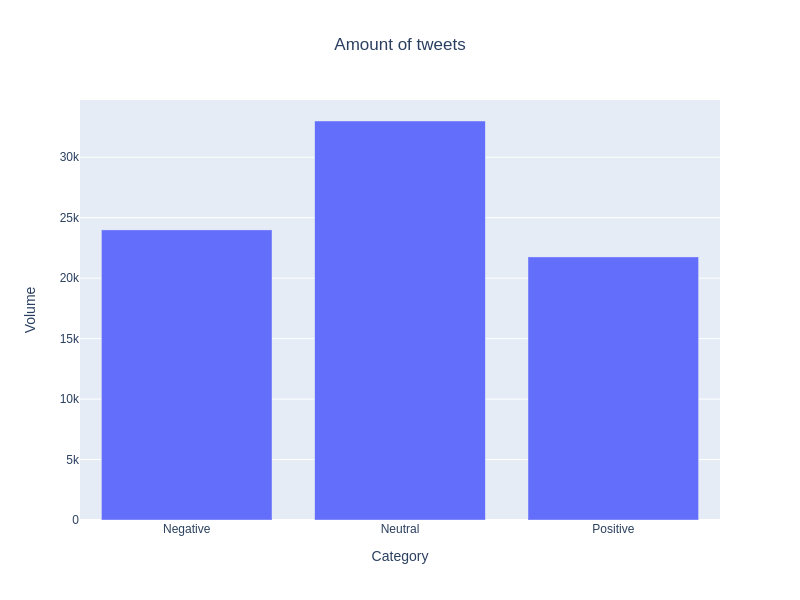

In [26]:
# Function to create a bar plot of positive, neutral and negative frequency of tweets
def barplot(df):
  data = df.groupby('category').count()
  fig = px.bar(data, 
               x=None, 
               y = "clean_text",
               width=800, 
               height=600, 
               title = "Amount of tweets", 
               labels = {"clean_text":"Volume",
                         "category":"Category"} )
  fig.update_layout(title_x = 0.5)
  fig.show("png", engine='orca')

barplot(df)

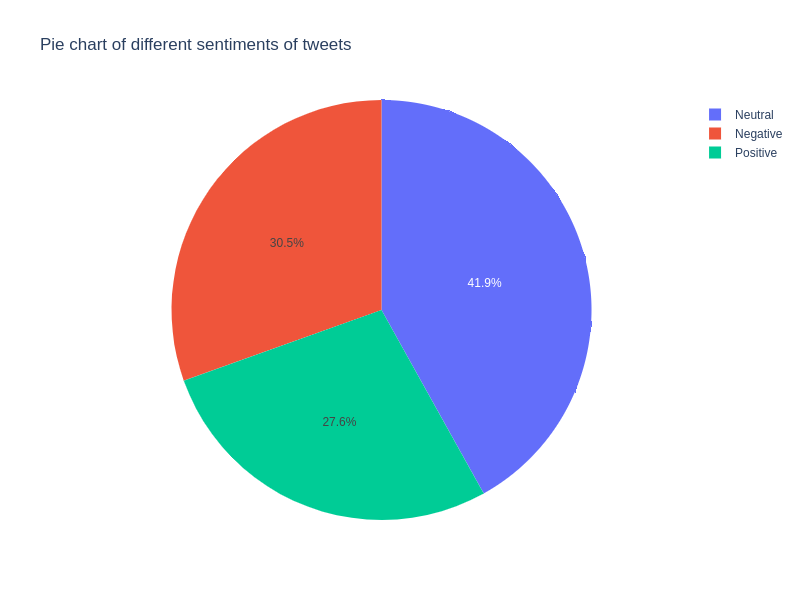

In [28]:
# Fucntion for pie chart visualisation of tweet distribution
def pie(df):
  fig = px.pie(df, 
               height=600, 
               width=800, 
               names = 'category',
               title = 'Pie chart of different sentiments of tweets')
  fig.show("png", engine='orca')

pie(df)  

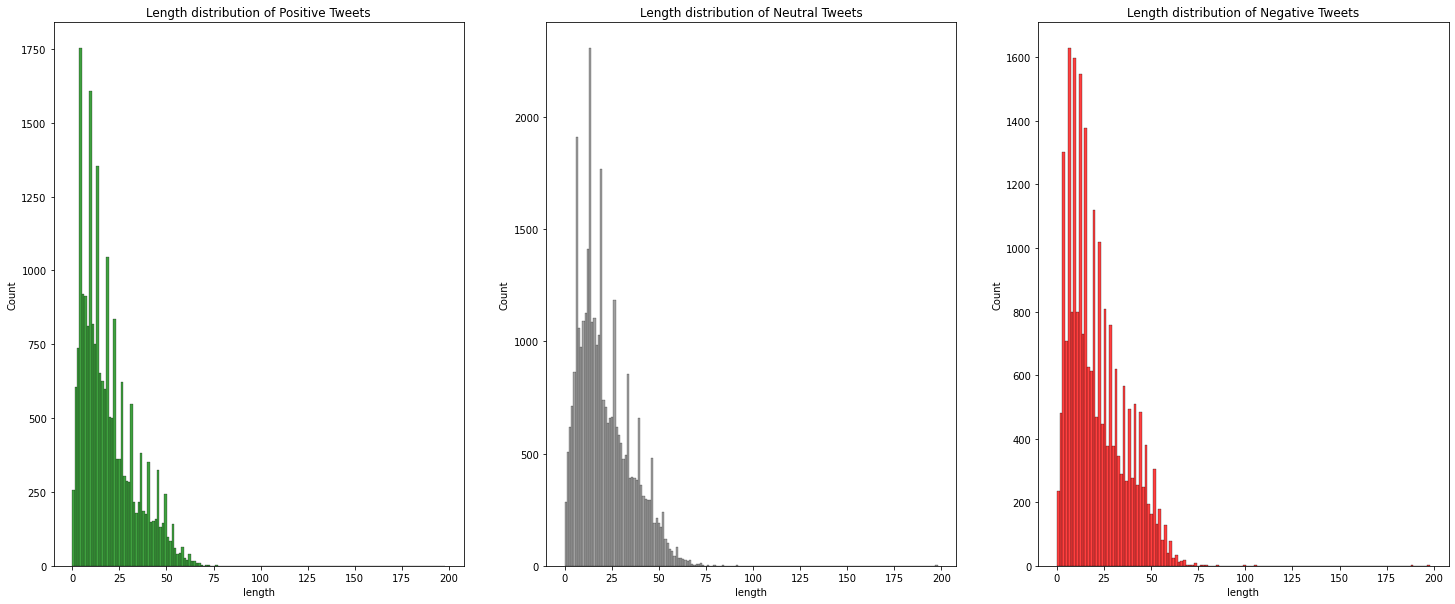

In [ ]:
# Function to plot a histplot of the distribution of tweets according to their lengths
# with respect to sentiment
def histplot(df):
  fig, ax = plt.subplots(ncols=3,
                         nrows=1,
                         figsize=(25,10))
  
  df['length'] = df['clean_text'].str.split().apply(len)
  
  catg = [ 'Positive', 'Neutral', 'Negative']
  col = ['green', 'grey', 'red']
  title = ["Length distribution of Positive Tweets",
           "Length distribution of Neutral Tweets",
           "Length distribution of Negative Tweets"]
  
  
  for i in range(3):
    sns.histplot(data=df[df['category']==catg[i]]['length'],
                 ax=ax[i],
                color=col[i])
    ax[i].set_title(title[i],
                    fontsize=12)

  df.drop('length', 
          axis=1, 
          inplace=True)

histplot(df)

<h2 align="center"> Data Preprocessing </h2>

In [ ]:
# Function to clean the text data by removing special characters, numbers, emoticons
# and stop words
stop_words = stopwords.words("english")
def text_preprs(x):
  x=x.lower()
  x=x.encode('ascii', 'ignore').decode()
  
  # Removing stop words
  nx = ""
  for w in x.split():
    if(w not in stop_words):
      nx = nx+" "+w
  x = nx
  
  x = re.sub(r'https*\S+', ' ', x)
  x = re.sub(r'@\S+', ' ', x)
  x = re.sub(r'#\S+', ' ', x)
  x = re.sub(r'\'\w+', '', x)
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  x = re.sub(r'\w*\d+\w*', '', x)
  x = re.sub(r'\s{2,}', ' ', x)
  
  return x

df['clean_text'] = df['clean_text'].apply(text_preprs)
df.sample(10, random_state=3)

,category,clean_text
31970,Positive,played csgo dead light feel like thunder clea...
12223,Neutral,yes pretty violent damn love franchise looks ...
33727,Positive,i say employee narri kind helped made feel go...
21195,Negative,bad dont c
51674,Negative,good morning svperfecta since pubg links rank...
7079,Positive,vaccinate people proper intervals
61876,Neutral,great stream thanks sadly came visit stream a...
13459,Positive,coincidentally went end game man missed game
16154,Negative,miss spam staying payload overwatch
82190,Positive,long term stock holdings really working me al...


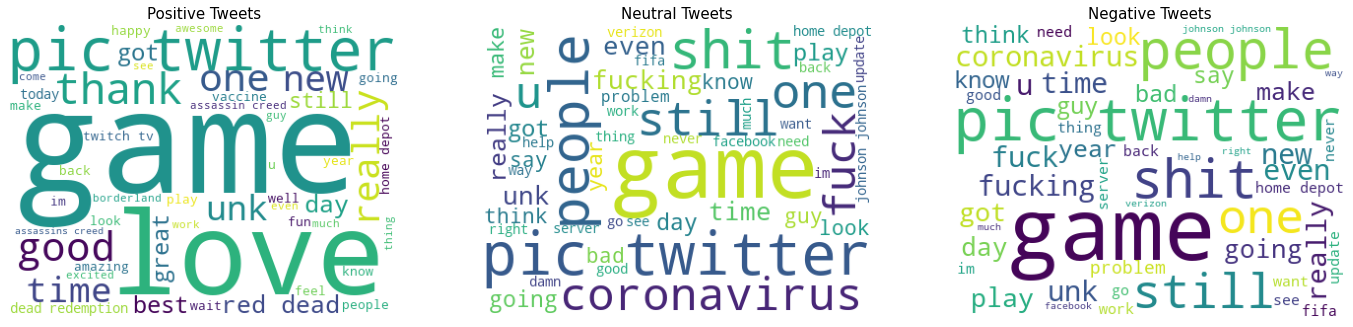

In [ ]:
# Function to create word cloud visualization
def wordcloudvis(df):

  # Combining tweets by setiment for plotting
  pos = ' '.join(tweet for tweet in df[df['category']=='Positive']['clean_text'])
  neg = ' '.join(tweet for tweet in df[df['category']=='Negative']['clean_text'])
  neu = ' '.join(tweet for tweet in df[df['category']=='Negative']['clean_text'])

  cat = [pos, neu, neg]
  title = ["Positive Tweets", "Neutral Tweets", "Negative Tweets"]

  fig, ax = plt.subplots(ncols=3,
                         nrows=1,
                         figsize=(24,10))

  wc = WordCloud(background_color='white',
                 width=400,
                 height=300,
                 stopwords=STOPWORDS,
                 max_words=50)
  
  # Plotting all three categories
  for i in range(3):
    ax[i].imshow(wc.generate(cat[i]))
    ax[i].set_title(title[i], 
                    fontsize=15)
    ax[i].axis('off')

wordcloudvis(df)

In [ ]:
# Function for lemmatizing the dataset
def lemma(text):
  text = text.split()
  text = ' '.join([WordNetLemmatizer().lemmatize(i) for i in text])
  return text

df['lemma'] = df['clean_text'].apply(lemma)
df.sample(10, random_state=3)

,category,clean_text,lemma
31970,Positive,played csgo dead light feel like thunder clea...,played csgo dead light feel like thunder clear...
12223,Neutral,yes pretty violent damn love franchise looks ...,yes pretty violent damn love franchise look great
33727,Positive,i say employee narri kind helped made feel go...,i say employee narri kind helped made feel goo...
21195,Negative,bad dont c,bad dont c
51674,Negative,good morning svperfecta since pubg links rank...,good morning svperfecta since pubg link rankin...
7079,Positive,vaccinate people proper intervals,vaccinate people proper interval
61876,Neutral,great stream thanks sadly came visit stream a...,great stream thanks sadly came visit stream ac...
13459,Positive,coincidentally went end game man missed game,coincidentally went end game man missed game
16154,Negative,miss spam staying payload overwatch,miss spam staying payload overwatch
82190,Positive,long term stock holdings really working me al...,long term stock holding really working me also...


In [ ]:
# Function to tokenize and pad the dataframe feature, i.e,
# lemmatized text
def token_and_pad(text):
  tokenizer = Tokenizer(num_words=10000, 
                        lower=True, 
                        split=' ')
  tokenizer.fit_on_texts(text)
  X = tokenizer.texts_to_sequences(text)
  X = pad_sequences(X, 
                    padding='post', 
                    maxlen=50)
  return X, tokenizer

In [ ]:
# Function to split the data into test and train dataset
def test_train(df):
  X, tokenizer = token_and_pad(df['lemma'])
  y = pd.get_dummies(df['category'])

  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2)
  return(X_train, 
         X_test, 
         y_train, 
         y_test)
  

X_train, X_test, y_train, y_test = test_train(df)
X_train, X_val, y_train, y_val = test_train(df)

<h2 align="center"> Neural Network Modeling </h3>

In [ ]:
# Defining Adaptive Learning Rate functions
def bl_step_decay(epoch):
    initial_lrate = 0.250
    drop = 0.8
    epochs_drop = 8.0
    lrate = initial_lrate * math.pow(drop,  
             math.floor((1+epoch)/epochs_drop))
    return lrate 

def cbl_step_decay(epoch):
   initial_lrate = 0.09
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate


In [ ]:
# Function to plot model's Train-Validation Accuracy and Loss
def plot_training_hist(history):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))

    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

In [ ]:
# Function for making predictions and testing model
def test(X_test, y_test,
         model,
         history):
  loss, accuracy, precision, recall = model.evaluate(X_test, y_test, 
                                                     verbose=0)
  f1 = (2*(precision*recall))/(precision+recall)
  
  # Print metrics
  print('')
  print('Accuracy  : {:.4f}'.format(accuracy))
  print('Precision : {:.4f}'.format(precision))
  print('Recall    : {:.4f}'.format(recall))
  print('F1 Score  : {:.4f}'.format(f1))

  # Storing the result in a dataframe
  metric = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
  value = [accuracy, precision, recall, f1]

  result = pd.DataFrame({
      'Metrics': metric,
      'Value': value
  })

  # Plotting Train-Validation Accuracy, Loss graph
  plot_training_hist(history)

  return result

<h3 align="center"> BiLSTM </h3>

In [ ]:
# Function for modeling a BiLSTM model
def BiLSTMmodel():
  model1=Sequential()
  model1.add(Embedding(10000,
                       7000,
                       input_length=50))
  model1.add(Bidirectional(LSTM(64,
                                kernel_regularizer=regularizers.l2(0.005),
                                return_sequences=True, 
                                input_shape=(3,1))))
  model1.add(Bidirectional(LSTM(32, 
                                dropout=0, 
                                kernel_regularizer=regularizers.l2(0.005))))
  model1.add(Dropout(0.3))
  model1.add(Dense(3, 
                   activation='softmax'))
  
  return model1

# Function for compiling BiLSTM model and training it
def BiLSTM_train(X_train, y_train,
                 X_val, y_val,
                 model):
  model.compile(loss='categorical_crossentropy',
                optimizer=SGD(),
                metrics=['accuracy',Precision(), Recall()])
  
  history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      callbacks =  LearningRateScheduler(bl_step_decay),
                      batch_size=50, epochs=30, verbose=1)
  return history

model1 = BiLSTMmodel()
history1 = BiLSTM_train(X_train, y_train,
                        X_val, y_val,
                        model1)

Epoch 1/30
1260/1260 [==============================] - 57s 40ms/step - loss: 2.0669 - accuracy: 0.4172 - precision_6: 0.5061 - recall_6: 0.0151 - val_loss: 1.0888 - val_accuracy: 0.4210 - val_precision_6: 1.0000 - val_recall_6: 1.9051e-04 - lr: 0.2500
Epoch 2/30
1260/1260 [==============================] - 49s 39ms/step - loss: 1.0702 - accuracy: 0.4405 - precision_6: 0.6028 - recall_6: 0.1157 - val_loss: 1.0141 - val_accuracy: 0.5306 - val_precision_6: 0.7186 - val_recall_6: 0.1698 - lr: 0.2500
Epoch 3/30
1260/1260 [==============================] - 48s 38ms/step - loss: 0.9882 - accuracy: 0.5519 - precision_6: 0.6386 - recall_6: 0.3576 - val_loss: 0.9262 - val_accuracy: 0.5975 - val_precision_6: 0.6679 - val_recall_6: 0.4486 - lr: 0.2500
Epoch 4/30
1260/1260 [==============================] - 49s 39ms/step - loss: 0.9319 - accuracy: 0.5947 - precision_6: 0.6642 - recall_6: 0.4590 - val_loss: 0.8707 - val_accuracy: 0.6390 - val_precision_6: 0.6994 - val_recall_6: 0.5385 - lr: 0.2500



Accuracy  : 0.8555
Precision : 0.8733
Recall    : 0.8354
F1 Score  : 0.8539


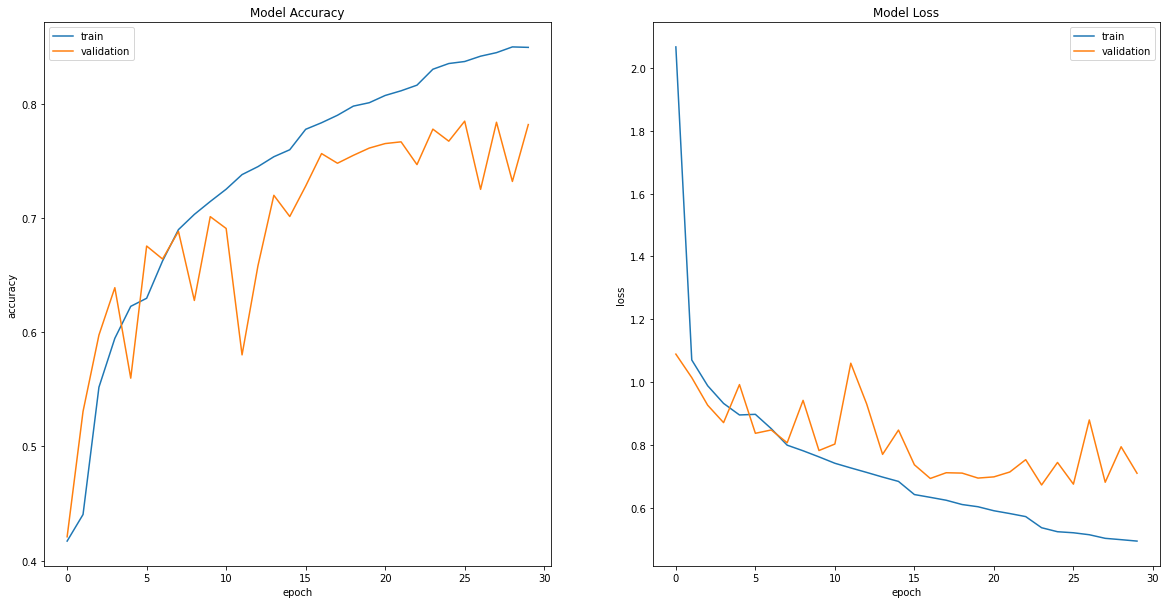

In [ ]:
# Testing BiLSTM model performance
BiLSTM_result = test(X_test, y_test,
                     model1,
                     history1)

<h3 align="center"> CNN-BiLSTM </h3>

In [ ]:
# Function for modeling a CNN-BiLSTM model
def CNN_BiLSTM():
  model2=Sequential()
  model2.add(Embedding(10000, 
                       6000, 
                       input_length=50))  
  model2.add(Conv1D(filters=70,
                    kernel_size=10, 
                    padding='same', 
                    activation='elu'))
  model2.add(MaxPooling1D(pool_size=10))
  model2.add(Bidirectional(LSTM(64, 
                                dropout=0.3, 
                                kernel_regularizer= regularizers.l2(0.005) )))
  model2.add(Dropout(0.2))
  model2.add(Dense(3, 
                   activation='softmax'))

  return model2

# Function for compiling the model and printing it
def CNN_BiLSTM_train(X_train, y_train,
                     X_val, y_val,
                     model):
  model.compile(loss='categorical_crossentropy', 
                optimizer=SGD(), 
                metrics=['accuracy', Precision(), Recall()])
  
  history = model.fit(X_train, y_train,
                      callbacks = LearningRateScheduler(cbl_step_decay),
                      validation_data=(X_val, y_val),
                      batch_size=48, epochs=15, verbose=1)
  return history

model2 = CNN_BiLSTM()
history2 = CNN_BiLSTM_train(X_train, y_train,
                            X_val, y_val,
                            model2)

Epoch 1/15
1313/1313 [==============================] - 56s 40ms/step - loss: 1.5002 - accuracy: 0.4176 - precision_5: 0.7270 - recall_5: 0.0114 - val_loss: 1.1655 - val_accuracy: 0.4218 - val_precision_5: 0.8235 - val_recall_5: 0.0512 - lr: 0.0900
Epoch 2/15
1313/1313 [==============================] - 51s 39ms/step - loss: 1.0763 - accuracy: 0.4645 - precision_5: 0.6944 - recall_5: 0.1193 - val_loss: 1.0085 - val_accuracy: 0.5484 - val_precision_5: 0.7688 - val_recall_5: 0.1603 - lr: 0.0900
Epoch 3/15
1313/1313 [==============================] - 51s 39ms/step - loss: 0.9083 - accuracy: 0.5907 - precision_5: 0.7203 - recall_5: 0.3695 - val_loss: 0.9491 - val_accuracy: 0.5675 - val_precision_5: 0.6085 - val_recall_5: 0.4659 - lr: 0.0900
Epoch 4/15
1313/1313 [==============================] - 50s 38ms/step - loss: 0.7229 - accuracy: 0.7116 - precision_5: 0.7780 - recall_5: 0.6115 - val_loss: 0.7110 - val_accuracy: 0.7048 - val_precision_5: 0.7499 - val_recall_5: 0.6383 - lr: 0.0900
Epoc


Accuracy  : 0.9571
Precision : 0.9653
Recall    : 0.9523
F1 Score  : 0.9588


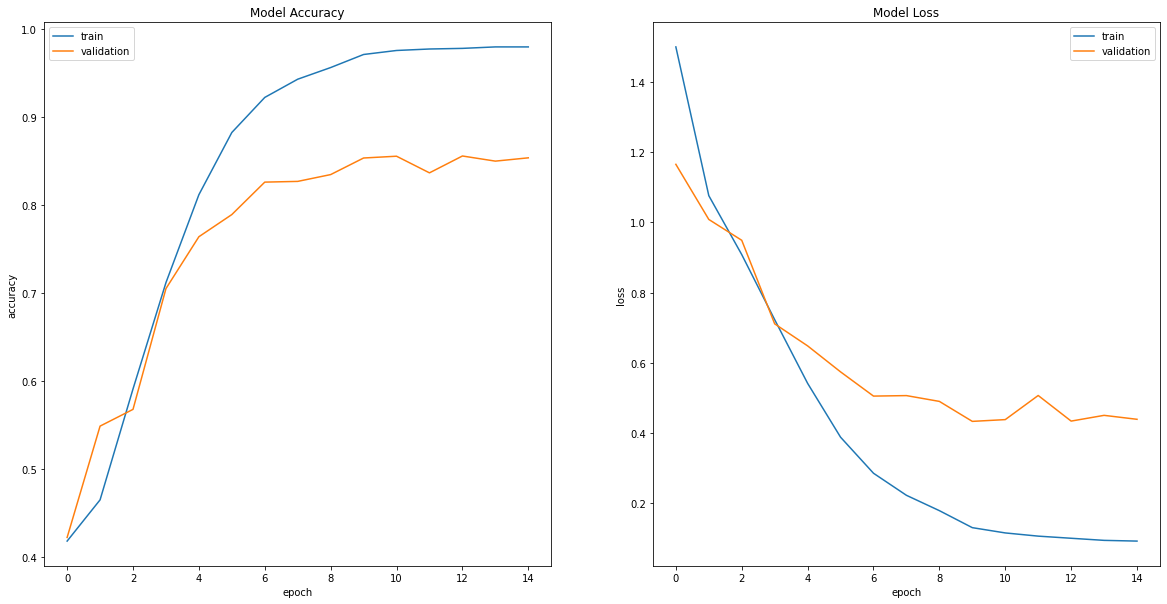

In [ ]:
# Testing CNN BiLSTM model performance
CNN_BiLSTM_result = test(X_test, y_test,
                         model2,
                         history2)

<h2 align="center"> Result </h2>

     Metrics    BiLSTM  CNN-BiLSTM
0   Accuracy  0.855528    0.957135
1  Precision  0.873332    0.965304
2     Recall  0.835397    0.952308
3   F1 Score  0.853944    0.958762 



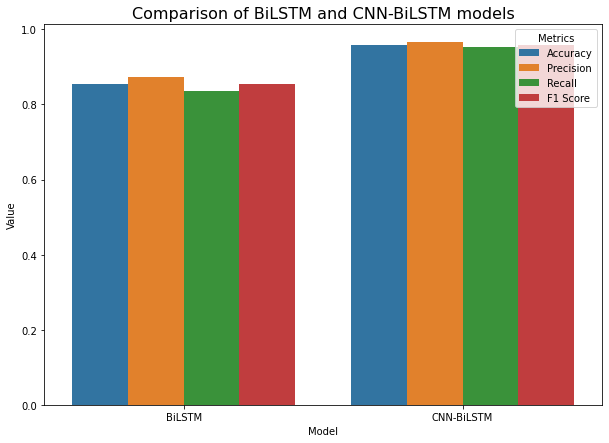

In [ ]:
# Function for plotting the results of BiLSTM and CNN-BiLSTM models
def result_plot(BiLSTM_result,
                CNN_BiLSTM_result):
  # Creating a temporary dataframe
  res = BiLSTM_result.copy()
  res.rename(columns={'Value':'BiLSTM'},
             inplace=True)
  res.insert(2, 
             "CNN-BiLSTM", 
             CNN_BiLSTM_result['Value'])
  print(res,'\n')
  res = res.melt(id_vars='Metrics').rename(columns=str.title)
  res.rename(columns={'Variable':'Model'},
             inplace=True)

  #Plotting the graph
  fig, ax = plt.subplots(figsize=(10,7))
  ax.set_title("Comparison of BiLSTM and CNN-BiLSTM models",
               fontsize=16)
  sns.barplot(x='Model',
              y='Value',
              hue='Metrics',
              data=res,
              ax=ax)

result_plot(BiLSTM_result,
           CNN_BiLSTM_result)